In [1]:
"""
@authors: faurand, chardes, ehagensieker
"""
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np 

#load the mnist dataset
(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info = True)


Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [2]:
def prepare_mnist_data(mnist):
  
  #flatten the images into one dimensional vector
  mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  #convert data from uint8 to float32
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #normalization to have input of range [-1,1]
  mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot vector targets
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  
  #cache this progress in memory - improve performance
  mnist = mnist.cache()
  #shuffle, batch, prefetch
  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(32)
  mnist = mnist.prefetch(20)

  #return preprocessed dataset
  return mnist

#apply the preprocessing to both data sets
train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

In [3]:
"""
@authors: faurand, chardes, ehagensieker
"""
from tensorflow.keras.layers import Dense

class MyModel(tf.keras.Model):
    
    def __init__(self):
        #initialize the model with n fully connected layer
        #inherits from tf.keras.Model
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        #self.dense3 = tf.keras.layers.Dense(128, activation=tf.nn.relu)
        #self.dense1 = tf.keras.layers.Dense(10, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        #implementation of the model's forward process
        x = self.dense1(inputs)
        x = self.dense2(x)
        #x = self.dense3(x)
        x = self.out(x)
        return x
    

In [4]:
def train_step(model, input, target, loss_function, optimizer):

  #computation of the model's prediciton and the loss 
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  #calculate the gradient to apply the optimizer
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  #get the accuracy of the train_step
  sample_train_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
  sample_train_accuracy = np.mean(sample_train_accuracy)

  train_accuracy_aggregator = [] 
  train_accuracy_aggregator.append(np.mean(sample_train_accuracy))
  train_accuracy = tf.reduce_mean(train_accuracy_aggregator)

  return loss, train_accuracy

def test(model, test_data, loss_function):

  #get a list saving all accuracies and losses to get the mean at the end
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  #test over complete test data
  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [5]:
tf.keras.backend.clear_session()

# subset of the train and test data set
train_dataset = train_dataset.take(1000)
test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 7
learning_rate = 0.001

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = [] 

#performance on accuracy and loss before we start the training (on test and train data)
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

#outputs the values for the test data
print("{:9}{:20}{:15}".format("Epoche", "Accuracy", "Loss"))

for epoch in range(num_epochs):
    #outputs the values for the test data after each epoch 
    print("{:<9d}{:<20f}{:<15f}".format(epoch, test_accuracies[-1], test_losses[-1]))

    #training (and checking in with training)
    epoch_loss_agg = []
    epoch_accuracy_agg = []

    #train the data
    for input,target in train_dataset:
        train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
        epoch_accuracy_agg.append(train_accuracy)

    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    train_accuracies.append(tf.reduce_mean(epoch_accuracy_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

 

Epoche   Accuracy            Loss           
0        0.093750            2.440090       
1        0.787813            0.884116       
2        0.850625            0.570611       
3        0.877188            0.461699       
4        0.886875            0.412607       
5        0.895312            0.387095       
6        0.898125            0.370065       


In [6]:
import matplotlib.pyplot as plt

def visualization(train_loss, test_loss, train_accuracies, test_accuracies): 
  #create two different plots for losses and accuracies
  fig, ax = plt.subplots(1, 2)

  #plot the losses
  ax[0].plot(train_loss, "b-", label = "train loss")
  ax[0].plot(test_loss, "r-", label = "test_loss")
  ax[0].legend(loc = "best")
  ax[0].set_xlabel("Training steps")
  ax[0].set_ylabel("Loss performance")

  #plot the accuracies
  ax[1].plot(train_accuracies , "b:", label = "train_accuracies")
  ax[1].plot(test_accuracies , "r:", label = "test_accuracies")
  ax[1].legend(loc = "best")
  ax[1].set_xlabel("Training steps")
  ax[1].set_ylabel("Accuracy performance")

  #move the plot to the right (to not have the label inside the ax[0] plot)
  box = ax[1].get_position() 
  box.x0 = box.x0 + 0.05
  box.x1 = box.x1 + 0.05
  ax[1].set_position(box)

  #set the title 
  fig.suptitle("Performance of the model")

  plt.show()

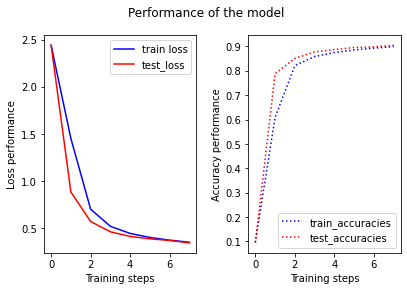

In [7]:
#visualize the losses and accuracies
visualization(train_losses, test_losses, train_accuracies, test_accuracies)